In [1]:
from IPython.display import display, clear_output
import keyboard
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = [9, 5]
plt.rcParams['figure.dpi'] = 300

#### Definimos: $$t(\omega)=\frac{-\kappa}{(\Omega-\omega)-i\kappa-i\frac{g^2}{i(\Delta E-\omega)+\gamma}}$$

In [2]:
def t_w (w, k, Omega, DeltaE, gamma, g):
    numerador = -k
    denominador = (Omega-w) - 1j * k - 1j * g**2 / (1j * (DeltaE - w) + gamma)
    t = numerador / denominador
    return abs(t)

 # Sin ruido

## Creamos base de datos

In [3]:
#Definimos una función que genere la base de datos
def Parameters_generator (num_datos):
    DeltaE = np.random.uniform(0.5, 1.5, num_datos)
    g = np.random.uniform(1e-4, 1e-2, num_datos)


    return DeltaE, g

num_datos = 5000

In [4]:
# #Creamos base de datos y guardamos en .txt
# DeltaE, g = Parameters_generator (num_datos)
# np.savetxt('Parameters_noNoise(kappa&gamma-fijos).txt', np.column_stack((DeltaE, g)), header='\u0394E g') 

In [5]:
datos = np.loadtxt('Parameters_noNoise(kappa&gamma-fijos).txt', skiprows=1)
DeltaE = datos[:,0]
g = datos[:,1]
k = 1e-3
gamma = 1e-3
Omega = 1

#Creamos los valores de y (la función t(w)) con nuestra base de datos
w_values = np.linspace(0.8, 1.2, 400)

# Crear una matriz para almacenar los t(w)
t_values = np.zeros((num_datos, len(w_values)))

# Almacenar los resultados en la matriz 
# (elemento [i,j] fila i es el número de combinación de [k, DeltaE, gamma, g] 
# y la comluna j el elemento de w_values)
for i in range (num_datos):
    t_values[i,:] = t_w(w_values, k, Omega, DeltaE[i], gamma, g[i])


### Dibujamos alguna curva

In [6]:
# i=0
# while i<=1000:
#     plt.clf()  # Limpia la figura antes de cada iteración
#     plt.plot(w_values, t_values[i,:], label='Curva original')
#     plt.plot(w_values, t_sep_values[i,:], linestyle='--', label='Curva separada')
#     plt.plot(w_values, mod_t_values[i,:], linestyle='-.', label='Módulo curva')
#     plt.title(f"Curva número: {i}")
#     plt.xlabel(r"$\omega$ (Hz)")
#     plt.ylabel(r"t ($\omega$)")
#     plt.legend()

#     plt.draw()  # Dibuja la figura actual

#     # Muestra la figura y espera a que el usuario presione Enter
#     display(plt.gcf())
#     clear_output(wait=True)
    
#     if keyboard.is_pressed('esc'): break
#     if keyboard.is_pressed('right'): i += 1
#     if keyboard.is_pressed('left'): 
#         i -= 1       
#         if i < 0:
#             i += 1

## Red neuronal

### Tensorflow/Keras

In [7]:
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from keras.constraints import NonNeg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#### Preparamos datos e hiperparámetros

In [8]:
#Seleccionamos los datos de entrenamiento y de validación
x_train, x_val, y_train, y_val = train_test_split(t_values, datos, test_size=0.2)

# Normalizamos los datos
scaler_x = StandardScaler()
x_train_norm = scaler_x.fit_transform(x_train)
x_val_norm = scaler_x.transform(x_val)

scaler_y = StandardScaler()
y_train_norm = scaler_y.fit_transform(y_train)
y_val_norm = scaler_y.transform(y_val)

# Comprobamos las dimensiones de nuestros datos
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'test samples')
print("x_train shape",x_train.shape)
print("y_train shape",y_train.shape)

#Número de neuronas de entrada y salida, y de la capa oculta
input_neurons  = x_train.shape[1]
output_neurons = y_train.shape[1]

#Elegimos los hiperparámetros
batch_size = 50
epochs = 1000
optimizer = Adam(learning_rate=0.001)


4000 train samples
1000 test samples
x_train shape (4000, 400)
y_train shape (4000, 2)


#### Definimos modelos

##### 5 capas ocultas



In [9]:
def Dense_five ():
    model = Sequential()
    model.add(Input(shape=(input_neurons,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32 , activation='relu'))
    model.add(Dense(16 , activation='relu'))
    model.add(Dense(output_neurons, activation='linear', kernel_constraint=NonNeg())) 

    #Compila el modelo
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

 #### Entrenamos y guardamos

Epoch 1/1000
80/80 - 1s - loss: 0.6899 - mean_absolute_error: 0.6748 - val_loss: 0.5708 - val_mean_absolute_error: 0.6023 - 1s/epoch - 13ms/step
Epoch 2/1000
80/80 - 0s - loss: 0.5143 - mean_absolute_error: 0.5443 - val_loss: 0.4464 - val_mean_absolute_error: 0.4935 - 164ms/epoch - 2ms/step
Epoch 3/1000
80/80 - 0s - loss: 0.4203 - mean_absolute_error: 0.4694 - val_loss: 0.3734 - val_mean_absolute_error: 0.4498 - 147ms/epoch - 2ms/step
Epoch 4/1000
80/80 - 0s - loss: 0.3563 - mean_absolute_error: 0.4208 - val_loss: 0.3269 - val_mean_absolute_error: 0.4062 - 151ms/epoch - 2ms/step
Epoch 5/1000
80/80 - 0s - loss: 0.3133 - mean_absolute_error: 0.3889 - val_loss: 0.2807 - val_mean_absolute_error: 0.3731 - 150ms/epoch - 2ms/step
Epoch 6/1000
80/80 - 0s - loss: 0.2714 - mean_absolute_error: 0.3547 - val_loss: 0.2441 - val_mean_absolute_error: 0.3423 - 147ms/epoch - 2ms/step
Epoch 7/1000
80/80 - 0s - loss: 0.2421 - mean_absolute_error: 0.3305 - val_loss: 0.2207 - val_mean_absolute_error: 0.320

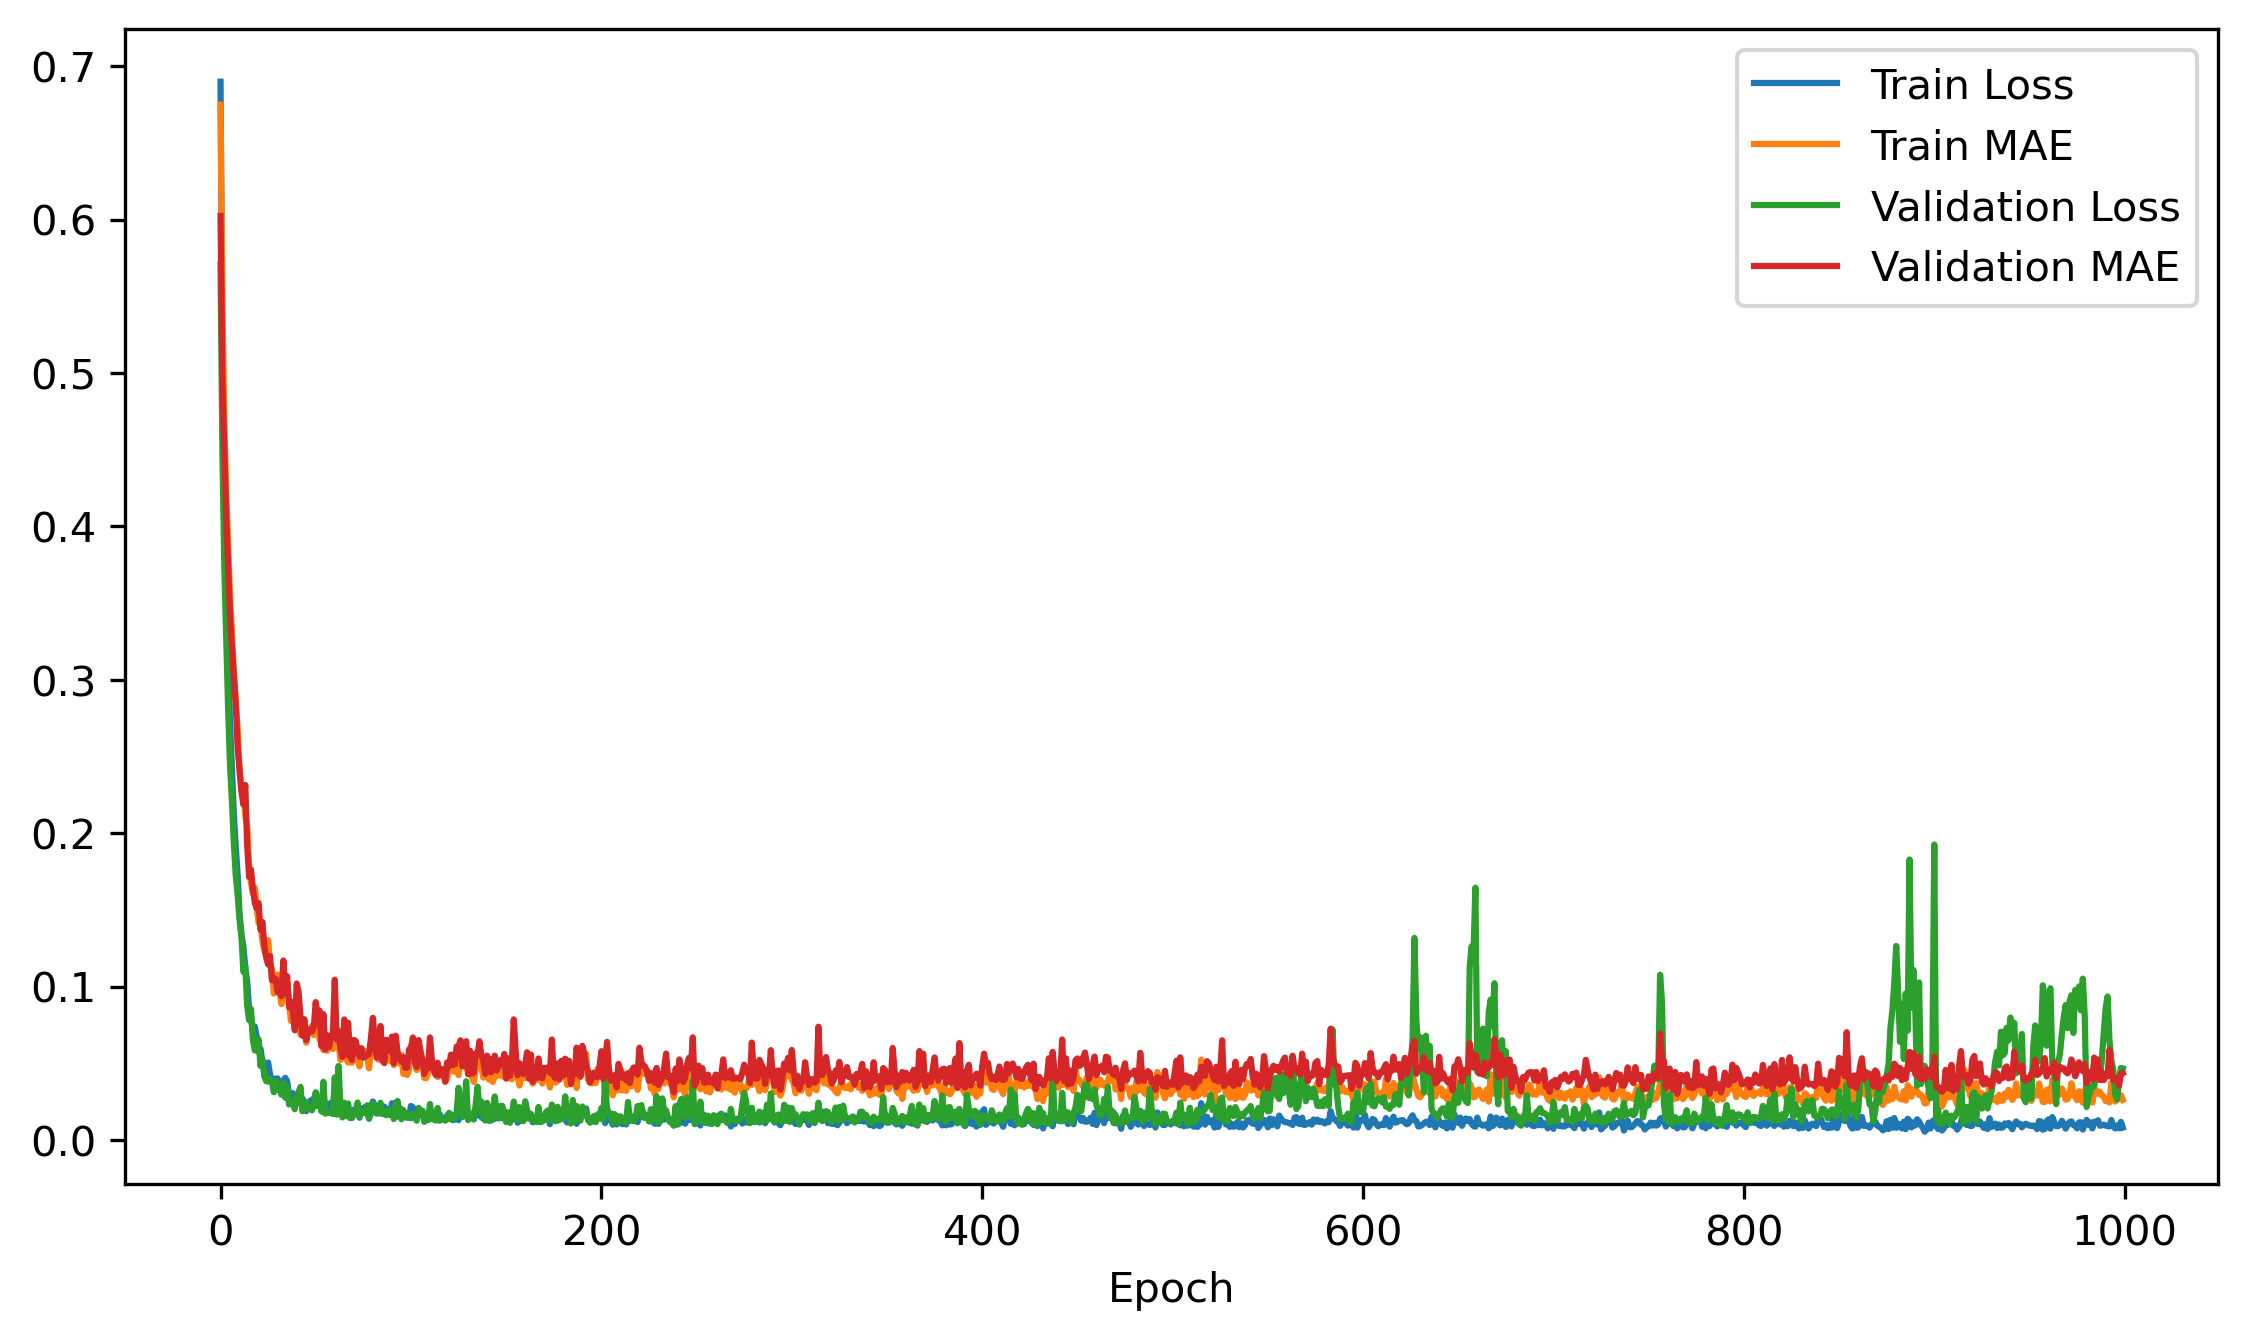

In [10]:
model =  Dense_five()

#Fiteamos el modelo
history = model.fit(x_train_norm, y_train_norm, batch_size=batch_size, validation_data=(x_val_norm, y_val_norm),
                     epochs=epochs, verbose=2)

# # Definir EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

#Guardamos el modelo y así no necesitamos entrenarlo cada vez que lo queramos usar
model.save('model_noNoise_five(k-1e-3&gamma-1e-3).keras') 

# Visualiza la pérdida y la métrica de entrenamiento
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Llamamos y evaluamos

In [11]:
#LLamamos al modelo
model = models.load_model("model_noNoise_five(k-1e-3&gamma-1e-3).keras")

#model.summary()

#Evaluamos el modelo
scores = model.evaluate(x_val_norm, y_val_norm, verbose=0)
print('MSE',scores[0],'\nMAE:', scores[1])  


#Predecimos los valores con nuestro modelo
y_pred_norm = model.predict(x_val_norm)

MSE 0.04657711461186409 
MAE: 0.04354993253946304
32/32 [==============================] - 0s 793us/step


#### Dibujamos los resultados

Predicción de cada parámetro

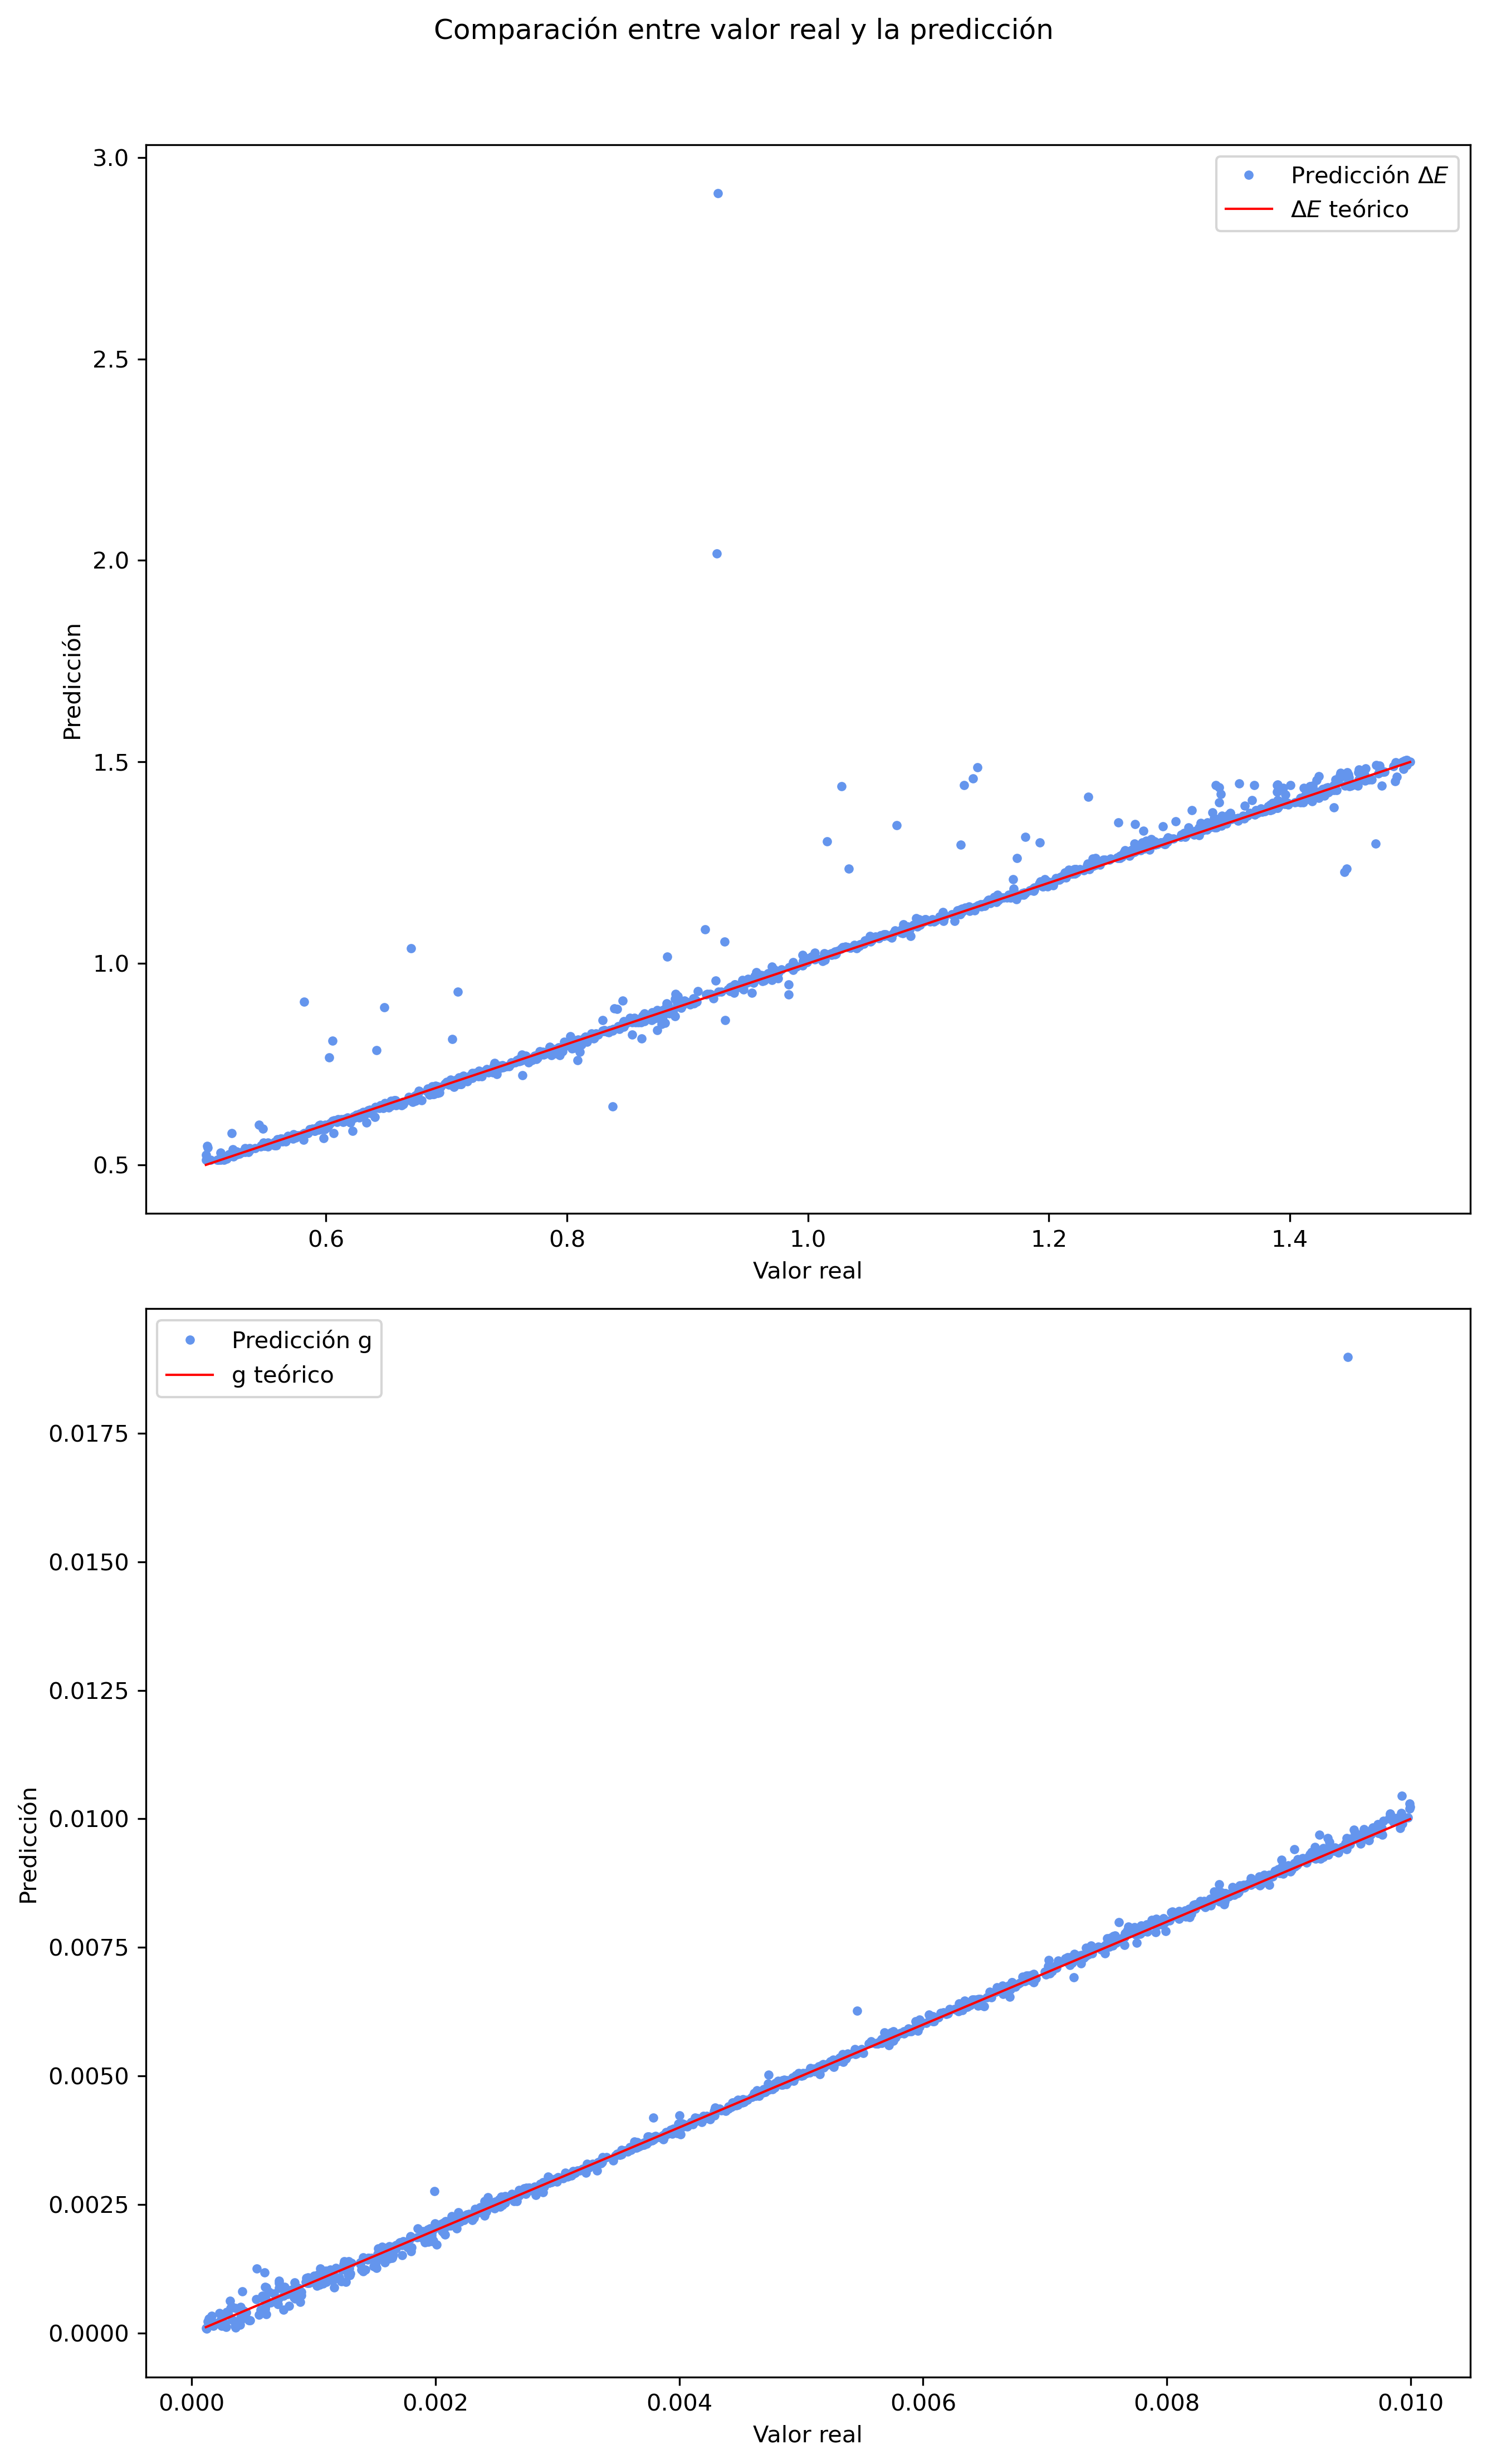

In [12]:
# Desnormalizamos los datos de salida de validación
y_val_denorm = scaler_y.inverse_transform(y_val_norm)
y_pred_denorm = scaler_y.inverse_transform(y_pred_norm)

#Dibujamos los datos
symbols = [r'$\Delta E$', r'g']

# Crear subgráficos para cada variable
fig, axes = plt.subplots(2,1, figsize=(9,15))

fig.suptitle('Comparación entre valor real y la predicción')

for i, ax in enumerate(axes):
    ax.plot(y_val_denorm[:, i], y_pred_denorm[:, i], label=f'Predicción {symbols[i]}', marker='o', linestyle='',
             markersize=3, color='cornflowerblue')
    ax.plot([y_val_denorm[:, i].min(), y_val_denorm[:, i].max()], [y_val_denorm[:, i].min(), y_val_denorm[:, i].max()],
            linestyle='-', color='red', linewidth=1, label=f'{symbols[i]} teórico')
    ax.set_xlabel('Valor real')
    ax.set_ylabel('Predicción')
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [13]:
def w_1(k, Omega, DeltaE, gamma, g):
    return 0.5 * ((DeltaE + Omega) + np.sqrt((DeltaE - Omega)**2 + 4*(k * gamma + g**2)))

def w_2(k, Omega, DeltaE, gamma, g):
    return 0.5 * ((DeltaE + Omega) - np.sqrt((DeltaE - Omega)**2 + 4*(k * gamma + g**2)))


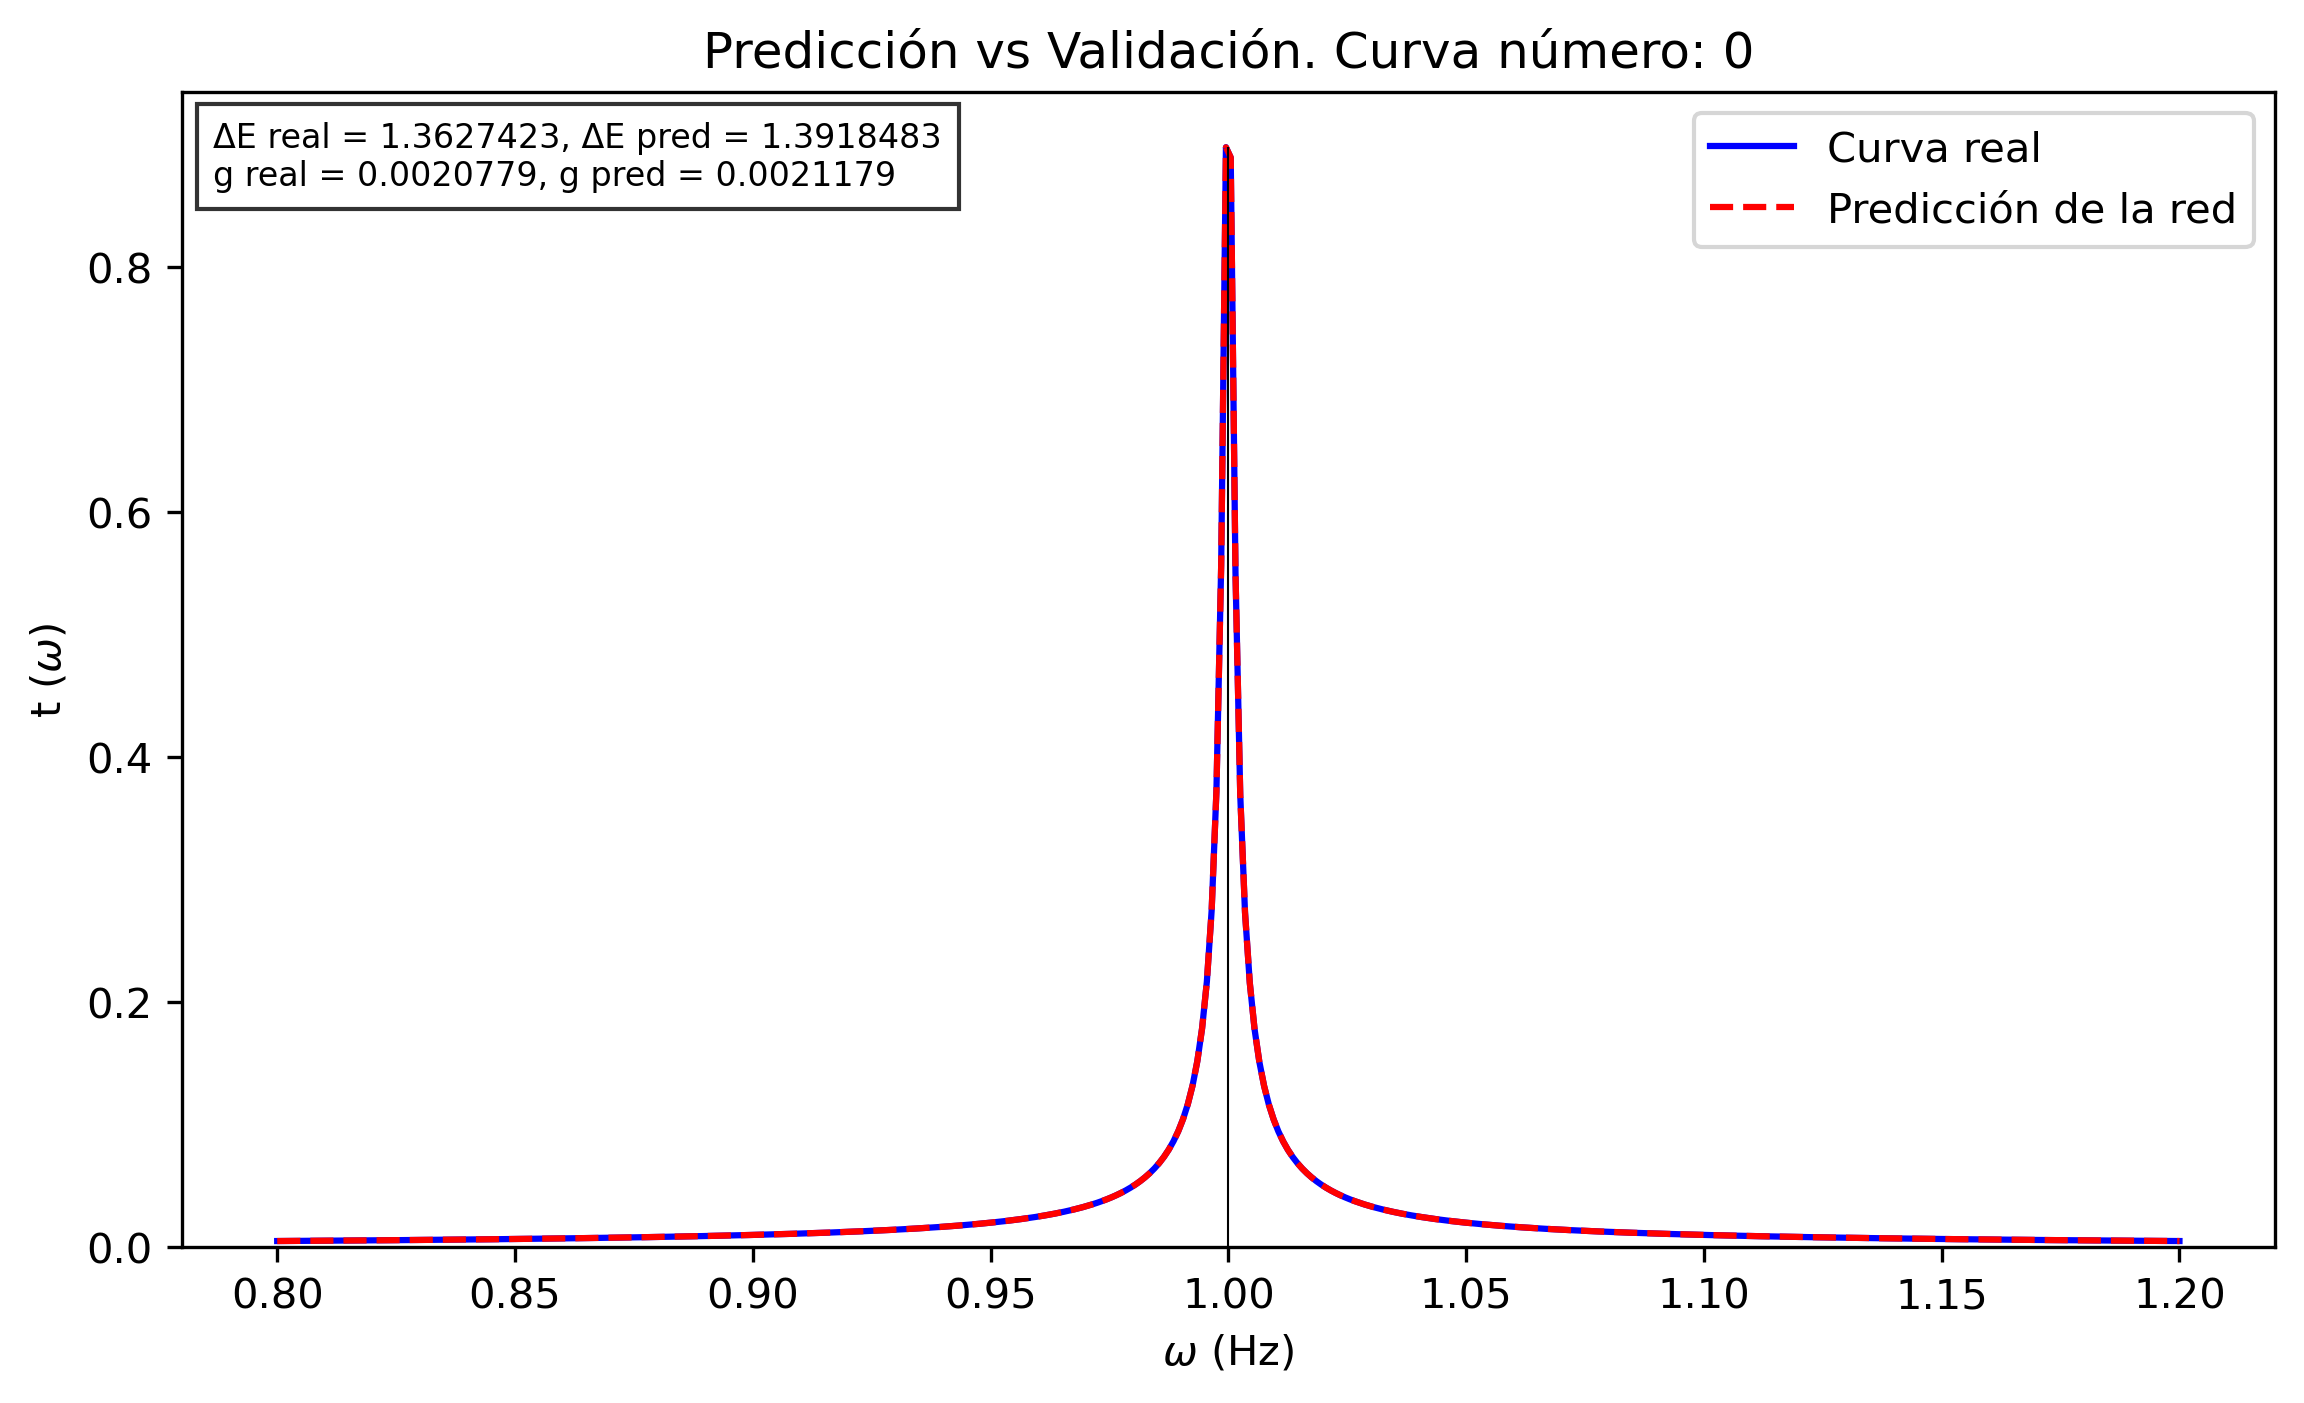

In [14]:
DeltaE_pred = y_pred_denorm[:, 0]
DeltaE_val = y_val_denorm[:, 0]
g_pred = y_pred_denorm[:, 1]
g_val = y_val_denorm[:, 1]


t_values_pred = np.zeros((x_val.shape[0], len(w_values)))
t_values_val = np.zeros((x_val.shape[0], len(w_values)))


for i in range (x_val.shape[0]):
    t_values_pred[i,:] = t_w(w_values, k, Omega, DeltaE_pred[i], gamma, g_pred[i])
    t_values_val[i,:] = t_w(w_values, k, Omega, DeltaE_val[i], gamma, g_val[i])

w1 = w2 = np.zeros(x_val.shape[0])

w1=w_1(k, Omega, DeltaE_val, gamma, g_val)
w2=w_2(k, Omega, DeltaE_val, gamma, g_val)

i = 0
while i < x_val.shape[0]:
    plt.clf()  # Limpia la figura antes de cada iteración
    plt.plot(w_values, t_values_val[i, :], color="b", label="Curva real")
    plt.plot(w_values, t_values_pred[i, :], color="r", linestyle="--", label="Predicción de la red")
    
    if w_values.min() <= w1[i] <= w_values.max():
        plt.vlines(w1[i], 0, t_values_val[i].max(), colors='black', linewidth=0.5)
    if w_values.min() <= w2[i] <= w_values.max():
        plt.vlines(w2[i], 0, t_values_val[i].max(), colors='black', linewidth=0.5)
   
    if w_values.min() <= w1[i] <= w_values.max() and w_values.min() <= w2[i] <= w_values.max():
        w_diff = abs(w1[i] - w2[i])
        if w_diff < 0.08:
            plt.hlines((t_values_val[i].min() + t_values_val[i].max()) / 10 *7, w1[i], w2[i],
                        colors='black', linestyle='--', linewidth=0.35)
            smaller_w = min(w1[i], w2[i])
            plt.text(smaller_w-0.01, (t_values_val[i].min() + t_values_val[i].max()) / 10 * 7,
                      f'|$\omega_1$-$\omega_2$| = {w_diff:.5f}', ha='right', va='bottom')
        else:
            plt.hlines((t_values_val[i].min() + t_values_val[i].max()) / 10 * 7, w1[i], w2[i], 
                       colors='black', linestyle='--', linewidth=0.35)
            plt.text((w1[i] + w2[i]) / 2, (t_values_val[i].min() + t_values_val[i].max()) / 10 * 7,
                      f'|$\omega_1$-$\omega_2$| = {w_diff:.5f}', ha='center', va='bottom')
   
    plt.title(f"Predicción vs Validación. Curva número: {i}")
    plt.xlabel(r"$\omega$ (Hz)")
    plt.ylabel(r"t ($\omega$)")
    plt.legend()
    plt.ylim(0, None) 

    # Muestra los valores como un recuadro dentro de la gráfica
    text = f"ΔE real = {DeltaE_val[i]:.7f}, ΔE pred = {DeltaE_pred[i]:.7f}\n"\
            f"g real = {g_val[i]:.7f}, g pred = {g_pred[i]:.7f}"
    plt.text(0.015, 0.975, text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='top', 
             bbox=dict(facecolor='white', alpha=0.8))

    # Muestra la figura
    display(plt.gcf())
    clear_output(wait=True)
    
    if keyboard.is_pressed('esc'): 
        break
    if keyboard.is_pressed('right'): 
        i += 1
    if keyboard.is_pressed('left'): 
        i -= 1       
        if i < 0:
            i += 1




# With noise